In [1]:
import sys
sys.path.append("..")
sys.path.append("../src/")
sys.path.append("../src/algs/")

from src import interface
from src import simulator
from src import algs

import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

In [2]:
def print_some_things(result_dict):
    for seed in result_dict.keys():
        print("Seed:", seed)
        for alg_name, res in result_dict[seed].items():
            print("Alg:", alg_name)
            weights, discarded_buyers, discarded_sellers, matched_wait_times = res
            avg_weight_matching = np.mean([w[0] for w in weights])
            n_matched_nodes = len(weights)*2 # because a match is 2 nodes
            num_discarded_buyers = np.sum([d[0] for d in discarded_buyers])
            num_discarded_sellers = np.sum([d[0] for d in discarded_sellers])
            n_nodes = n_matched_nodes + num_discarded_buyers + num_discarded_sellers
            avg_weight_per_node = (avg_weight_matching * n_matched_nodes) / n_nodes
            print("Average weight per matching:", avg_weight_matching)
            print("Average weight per node:", avg_weight_per_node)
            print("Number of nodes: {}, matches: {}".format(n_nodes, len(weights)))
            print("Number of dropped buyers: {}, sellers: {}".format(
                num_discarded_buyers,
                num_discarded_sellers
            ))

In [54]:
def print_some_more_things(result_dict):
    # Prints to Latex table
    to_print = dict()
    keys = ['algorithm', 'Avg weight per matching', 'Avg weight per node', '$\sigma$ weight per node']
    for k in keys:
        to_print[k] = []
    
    to_print_2 = dict()
    keys = ['algorithm', 'Discarded buyers', 'Discarded sellers']
    for k in keys:
        to_print_2[k] = []
    
    for alg_name, res in result_dict[seed].items():
        weights, discarded_buyers, discarded_sellers, matched_wait_times = res
        avg_weight_matching = np.mean([w[0] for w in weights])
        n_matched_nodes = len(weights)*2 # because a match is 2 nodes
        num_discarded_buyers = np.sum([d[0] for d in discarded_buyers])
        num_discarded_sellers = np.sum([d[0] for d in discarded_sellers])
        n_nodes = n_matched_nodes + num_discarded_buyers + num_discarded_sellers
        avg_weight_per_node = (avg_weight_matching * n_matched_nodes) / n_nodes
        to_print['algorithm'].append(alg_name)
        to_print_2['algorithm'].append(alg_name)
        to_print['Avg weight per matching'].append(avg_weight_matching)
        to_print['Avg weight per node'].append(avg_weight_per_node)
        to_print_2['Discarded buyers'].append(100*num_discarded_buyers / n_nodes)
        to_print_2['Discarded sellers'].append(100*num_discarded_sellers / n_nodes)
        just_weights = [w[0] for w in weights]
        weights_with_0s = []
        for match in just_weights:
            weights_with_0s.extend([match,match])
        weights_with_0s.extend([0]*(num_discarded_buyers + num_discarded_sellers))
        to_print['$\sigma$ weight per node'].append(np.std(weights_with_0s))
        
    for key, vals in to_print.items():
        print('\n', key, end='')
        for val in vals:
            print(' & ', val, end='')
        print(" \\\\", end="")
    
    print('\n')
    for key, vals in to_print_2.items():
        print('\n', key, end='')
        for val in vals:
            print(' & ', val, end='')
        print(" \\\\", end="")
        
        

# Let's run a few experiments...

In [4]:
def run_an_experiment(seed, p_node, departure_distr, algs_to_test, weight_fn,
                      fewest_nodes_per_add=1, max_nodes_per_add=10,
                      p_buyer=0.5, num_runs=1000, size=(10,10), recalc=False):
    results = {}
    for (alg_name, alg) in algs_to_test:
        inter = interface.Interface(
            alg,
            simulator.Simulator(weight_fn),
            p_node=p_node,
            min_to_add=fewest_nodes_per_add,
            max_to_add=max_nodes_per_add,
            p_buyer=p_buyer,
            seed=seed,
            dep_distr=departure_distr,
            recalc_weights=recalc)
        results[alg_name] = inter.run(num_runs)
    for alg_name, res in results.items():
        average_weight =  np.mean([w[0] for w in res[0]])
        print("The {} algorithm had an average weight of {}".format(alg_name, average_weight))
    return results


In [5]:
def make_dataframe(results, seed=0):
    aggregates = {}
    for alg_name, res in results[seed].items():
        weights, discarded_buyers, discarded_sellers, matched_wait_times = res
        just_weights = [w[0] for w in weights]
        avg_weight_matching = np.mean(just_weights)
        n_matched_nodes = len(weights)*2 # because a match is 2 nodes
        num_discarded_buyers = np.sum([d[0] for d in discarded_buyers])
        num_discarded_sellers = np.sum([d[0] for d in discarded_sellers])
        n_nodes = n_matched_nodes + num_discarded_buyers + num_discarded_sellers
        avg_weight_per_node = (avg_weight_matching * n_matched_nodes) / n_nodes
        this_alg_aggregates = {}
        this_alg_aggregates["avg_weight_matching"] = avg_weight_matching
        this_alg_aggregates["avg_weight_per_node"] = avg_weight_per_node
        weights_with_0s = []
        for match in just_weights:
            weights_with_0s.extend([match,match])
        weights_with_0s.extend([0]*(num_discarded_buyers + num_discarded_sellers))
        this_alg_aggregates["weight_per_node_stddev"] = np.std(weights_with_0s)
        this_alg_aggregates["num_discarded_sellers"] = num_discarded_sellers
        this_alg_aggregates["num_discarded_buyers"] = num_discarded_buyers
        aggregates[alg_name] = this_alg_aggregates
    return pd.DataFrame(aggregates)



### Fixed departures, pure distance weight function, balanced market

In [47]:
algs_to_test = [
    ("Greedy", algs.Greedy()),
    ("DDA", algs.DynamicDeferredAcceptance()),
    ("LookAhead1", algs.DeferredWithLookAhead(1)),
    ("LookAhead3", algs.DeferredWithLookAhead(3)),
    ("LookAhead5", algs.DeferredWithLookAhead(5))
]

In [7]:
def weight_function_distance(buyer_pos, buyer_d, seller_pos, seller_d):
    bx, by = buyer_pos
    sx, sy = seller_pos
    return 1/(1 + (bx-sx)**2 + (by-sy)**2)

In [48]:
results1 = {}
for seed in range(0,1):
    print("\nSeed:", seed)
    results1[seed] = run_an_experiment(seed, 0.9, (6,0), algs_to_test, weight_function_distance,
                      fewest_nodes_per_add=1, max_nodes_per_add=6,
                      p_buyer=0.5, num_runs=500, size=(10,10))
make_dataframe(results1)


Seed: 0
The Greedy algorithm had an average weight of 0.44916960832973013
The DDA algorithm had an average weight of 0.35383355067916966
The LookAhead1 algorithm had an average weight of 0.3462263137614577
The LookAhead3 algorithm had an average weight of 0.337721109605453
The LookAhead5 algorithm had an average weight of 0.3686430787009736


,DDA,Greedy,LookAhead1,LookAhead3,LookAhead5
avg_weight_matching,0.353834,0.449170,0.346226,0.337721,0.368643
avg_weight_per_node,0.241494,0.228318,0.227991,0.229550,0.250938
num_discarded_buyers,228.000000,347.000000,232.000000,229.000000,241.000000
num_discarded_sellers,253.000000,363.000000,270.000000,246.000000,229.000000
weight_per_node_stddev,0.284968,0.311412,0.270724,0.274122,0.301715


In [49]:
print_some_more_things(results1)


 algorithm &  Greedy &  DDA &  LookAhead1 &  LookAhead3 &  LookAhead5 \\
 avg weight per matching &  0.44916960832973013 &  0.35383355067916966 &  0.3462263137614577 &  0.337721109605453 &  0.3686430787009736 \\
 avg weight per node &  0.2283175155914279 &  0.24149431775726826 &  0.22799120525244287 &  0.22955015406763088 &  0.2509377478657443 \\
 $\sigma$ weight per node &  0.3114116835588558 &  0.28496808811924396 &  0.270723875213394 &  0.27412199637670853 &  0.3017151150633318 \\


 algorithm &  Greedy &  DDA &  LookAhead1 &  LookAhead3 &  LookAhead5 \\
 discarded buyers &  24.030470914127424 &  15.049504950495049 &  15.782312925170068 &  15.441672285906945 &  16.372282608695652 \\
 discarded sellers &  25.138504155124654 &  16.699669966996698 &  18.367346938775512 &  16.587997302764666 &  15.557065217391305 \\

### Fixed departures, pure distance weight function, p_buyer = 0.3

In [50]:
results_pb = {}
for seed in range(0,1):
    print("\nSeed:", seed)
    results_pb[seed] = run_an_experiment(seed, 0.9, (6,0), algs_to_test, weight_function_distance,
                      fewest_nodes_per_add=1, max_nodes_per_add=6,
                      p_buyer=0.3, num_runs=500, size=(10,10))
make_dataframe(results_pb)


Seed: 0
The Greedy algorithm had an average weight of 0.43695055072052963
The DDA algorithm had an average weight of 0.42119629579746126
The LookAhead1 algorithm had an average weight of 0.4402097441460022
The LookAhead3 algorithm had an average weight of 0.41221691714501535
The LookAhead5 algorithm had an average weight of 0.4035989693170042


,DDA,Greedy,LookAhead1,LookAhead3,LookAhead5
avg_weight_matching,0.421196,0.436951,0.440210,0.412217,0.403599
avg_weight_per_node,0.185742,0.169859,0.189746,0.183830,0.176053
num_discarded_buyers,128.000000,138.000000,117.000000,108.000000,117.000000
num_discarded_sellers,734.000000,752.000000,741.000000,707.000000,674.000000
weight_per_node_stddev,0.281030,0.271242,0.285932,0.281404,0.277244


In [51]:
print_some_more_things(results_pb)


 algorithm &  Greedy &  DDA &  LookAhead1 &  LookAhead3 &  LookAhead5 \\
 avg weight per matching &  0.43695055072052963 &  0.42119629579746126 &  0.4402097441460022 &  0.41221691714501535 &  0.4035989693170042 \\
 avg weight per node &  0.16985852452460148 &  0.18574155716100757 &  0.18974557937327682 &  0.18383024993006802 &  0.17605314983749576 \\
 $\sigma$ weight per node &  0.27124208318669196 &  0.2810300656695929 &  0.28593216327701065 &  0.28140398939818695 &  0.27724375258546297 \\


 algorithm &  Greedy &  DDA &  LookAhead1 &  LookAhead3 &  LookAhead5 \\
 discarded buyers &  9.478021978021978 &  8.300907911802854 &  7.758620689655173 &  7.341944255608429 &  8.33927298645759 \\
 discarded sellers &  51.64835164835165 &  47.60051880674449 &  49.13793103448276 &  48.06254248810333 &  48.03991446899501 \\

### Fixed departures, pure distance weight function, p_buyer = 0.7

In [52]:
results_pb2 = {}
for seed in range(0,1):
    print("\nSeed:", seed)
    results_pb2[seed] = run_an_experiment(seed, 0.9, (6,0), algs_to_test, weight_function_distance,
                      fewest_nodes_per_add=1, max_nodes_per_add=6,
                      p_buyer=0.7, num_runs=500, size=(10,10))
make_dataframe(results_pb2)


Seed: 0
The Greedy algorithm had an average weight of 0.4155892115558785
The DDA algorithm had an average weight of 0.3719102486920567
The LookAhead1 algorithm had an average weight of 0.34425583990328407
The LookAhead3 algorithm had an average weight of 0.3500628649240023
The LookAhead5 algorithm had an average weight of 0.35784369592849


,DDA,Greedy,LookAhead1,LookAhead3,LookAhead5
avg_weight_matching,0.371910,0.415589,0.344256,0.350063,0.357844
avg_weight_per_node,0.213513,0.200152,0.196455,0.207409,0.211894
num_discarded_buyers,624.000000,638.000000,617.000000,579.000000,579.000000
num_discarded_sellers,14.000000,109.000000,27.000000,18.000000,23.000000
weight_per_node_stddev,0.279558,0.284121,0.267519,0.276219,0.284897


In [53]:
print_some_more_things(results_pb2)


 algorithm &  Greedy &  DDA &  LookAhead1 &  LookAhead3 &  LookAhead5 \\
 avg weight per matching &  0.4155892115558785 &  0.3719102486920567 &  0.34425583990328407 &  0.3500628649240023 &  0.35784369592849 \\
 avg weight per node &  0.20015191729339327 &  0.21351322688596044 &  0.19645533263814077 &  0.20740926058295836 &  0.2118938958275747 \\
 $\sigma$ weight per node &  0.2841210129845348 &  0.2795575115955846 &  0.26751888549798275 &  0.2762189757549327 &  0.28489725910878755 \\


 algorithm &  Greedy &  DDA &  LookAhead1 &  LookAhead3 &  LookAhead5 \\
 discarded buyers &  44.274809160305345 &  41.655540720961284 &  41.13333333333333 &  39.522184300341294 &  39.22764227642276 \\
 discarded sellers &  7.5641915336571826 &  0.9345794392523364 &  1.8 &  1.2286689419795223 &  1.5582655826558265 \\

### Fixed departures, time and distance weight function(s), balanced market

In [14]:
# difference is weighting of time / distance components.
def weight_function_d_and_time_sep1(buyer_pos, buyer_d, seller_pos, seller_d):
    # mu = 1
    bx, by = buyer_pos
    sx, sy = seller_pos
    return 1/(buyer_d + seller_d) + 1/(1 + (bx-sx)**2 + (by-sy)**2)
def weight_function_d_and_time_sep2(buyer_pos, buyer_d, seller_pos, seller_d):
    # mu = 10
    bx, by = buyer_pos
    sx, sy = seller_pos
    return 1/(buyer_d + seller_d) + 10*1/(1 + (bx-sx)**2 + (by-sy)**2)
def weight_function_d_and_time_sep3(buyer_pos, buyer_d, seller_pos, seller_d):
    # mu = 1/10
    bx, by = buyer_pos
    sx, sy = seller_pos
    return 1/(buyer_d + seller_d) + 0.1/(1 + (bx-sx)**2 + (by-sy)**2)

results_time_sep_1 = {}
results_time_sep_2 = {}
results_time_sep_3 = {}
seed = 0
results_time_sep_1[seed] = run_an_experiment(
    seed, 0.9, (6,0), algs_to_test, 
    weight_function_d_and_time_sep1,
    fewest_nodes_per_add=1, max_nodes_per_add=6,
    p_buyer=0.5, num_runs=500, size=(10,10), recalc=True)
results_time_sep_2[seed] = run_an_experiment(
    seed, 0.9, (6,0), algs_to_test, 
    weight_function_d_and_time_sep2,
    fewest_nodes_per_add=1, max_nodes_per_add=6,
    p_buyer=0.5, num_runs=500, size=(10,10), recalc=True)
results_time_sep_3[seed] = run_an_experiment(
    seed, 0.9, (6,0), algs_to_test, 
    weight_function_d_and_time_sep3,
    fewest_nodes_per_add=1, max_nodes_per_add=6,
    p_buyer=0.5, num_runs=500, size=(10,10), recalc=True)
    

The Greedy algorithm had an average weight of 0.6554656408291908
The DDA algorithm had an average weight of 0.5698972137486943
The Lookahead(1) algorithm had an average weight of 0.5757939300877712
The Lookahead(3) algorithm had an average weight of 0.5785427248419591
The Lookahead(5) algorithm had an average weight of 0.5699060513831903
The Greedy algorithm had an average weight of 4.294584614907241
The DDA algorithm had an average weight of 3.7320381994264746
The Lookahead(1) algorithm had an average weight of 3.8578350875161624
The Lookahead(3) algorithm had an average weight of 3.6245117935934412
The Lookahead(5) algorithm had an average weight of 3.5812595954334325
The Greedy algorithm had an average weight of 0.34000863194636743
The DDA algorithm had an average weight of 0.2922867471423604
The Lookahead(1) algorithm had an average weight of 0.3071590831693432
The Lookahead(3) algorithm had an average weight of 0.29059360459474365
The Lookahead(5) algorithm had an average weight o

In [58]:
make_dataframe(results_time_sep_1)
print_some_more_things(results_time_sep_1)


 algorithm &  Greedy &  DDA &  Lookahead(1) &  Lookahead(3) &  Lookahead(5) \\
 Avg weight per matching &  0.6554656408291908 &  0.5698972137486943 &  0.5757939300877712 &  0.5785427248419591 &  0.5699060513831903 \\
 Avg weight per node &  0.4366812393878969 &  0.44238951517463443 &  0.45209900893645183 &  0.46917225648506233 &  0.4589442109152049 \\
 $\sigma$ weight per node &  0.40409672178766026 &  0.36249405507824695 &  0.3669711568681779 &  0.35981151959103197 &  0.353345537628684 \\


 algorithm &  Greedy &  DDA &  Lookahead(1) &  Lookahead(3) &  Lookahead(5) \\
 Discarded buyers &  17.806364251861883 &  12.346521145975444 &  9.059711736444749 &  10.08684034736139 &  10.66225165562914 \\
 Discarded sellers &  15.572105619498984 &  10.027285129604365 &  12.422786547700754 &  8.817635270541082 &  8.80794701986755 \\

In [59]:
make_dataframe(results_time_sep_2)
print_some_more_things(results_time_sep_2)


 algorithm &  Greedy &  DDA &  Lookahead(1) &  Lookahead(3) &  Lookahead(5) \\
 Avg weight per matching &  4.294584614907241 &  3.7320381994264746 &  3.8578350875161624 &  3.6245117935934412 &  3.5812595954334325 \\
 Avg weight per node &  2.3988282031646007 &  2.6671903436118556 &  2.7237800485183787 &  2.4932029435056275 &  2.529138132368243 \\
 $\sigma$ weight per node &  2.912669323549763 &  2.975631835628251 &  3.0270815730223846 &  2.8643539697257143 &  2.8531364078931674 \\


 algorithm &  Greedy &  DDA &  Lookahead(1) &  Lookahead(3) &  Lookahead(5) \\
 Discarded buyers &  22.832561217736597 &  16.23641304347826 &  16.65560716655607 &  14.181577203445991 &  15.18361581920904 \\
 Discarded sellers &  21.31039046988749 &  12.296195652173912 &  12.74054412740544 &  17.0311464546057 &  14.194915254237289 \\

In [60]:
make_dataframe(results_time_sep_3)
print_some_more_things(results_time_sep_3)


 algorithm &  Greedy &  DDA &  Lookahead(1) &  Lookahead(3) &  Lookahead(5) \\
 Avg weight per matching &  0.34000863194636743 &  0.2922867471423604 &  0.3071590831693432 &  0.29059360459474365 &  0.3094370044424819 \\
 Avg weight per node &  0.2758690725731176 &  0.26044973925152587 &  0.271829553982071 &  0.26421127467158934 &  0.2697442792252126 \\
 $\sigma$ weight per node &  0.17750550672252893 &  0.15113701358623755 &  0.154719656168405 &  0.1454229786257053 &  0.1560954445146997 \\


 algorithm &  Greedy &  DDA &  Lookahead(1) &  Lookahead(3) &  Lookahead(5) \\
 Discarded buyers &  11.156186612576064 &  5.511811023622047 &  7.171853856562923 &  4.606141522029373 &  8.059100067159168 \\
 Discarded sellers &  7.707910750507099 &  5.380577427821522 &  4.330175913396482 &  4.472630173564753 &  4.768300873069174 \\

## Stochastic Departures

In [18]:
algs_to_test = [
    ("dfa_stoch1", algs.DynamicDeferredAcceptance(stochastic=True, guess=1)),
    ("dfa_stoch2", algs.DynamicDeferredAcceptance(stochastic=True, guess=2)),
    ("dfa_stoch3", algs.DynamicDeferredAcceptance(stochastic=True, guess=3)),
    ("dfa_stoch4", algs.DynamicDeferredAcceptance(stochastic=True, guess=4)),
    ("dfa_stoch5", algs.DynamicDeferredAcceptance(stochastic=True, guess=5)),
    ("dfa_stoch6", algs.DynamicDeferredAcceptance(stochastic=True, guess=6)),
    ("dfa_stoch7", algs.DynamicDeferredAcceptance(stochastic=True, guess=7)),

]

### Stochastic departures, pure distance weight function, balanced market

In [19]:
results1s = {}
for seed in range(0,1):
    print("\nSeed:", seed)
    results1s[seed] = run_an_experiment(seed, 0.9, (6,1), algs_to_test, weight_function_distance,
                      fewest_nodes_per_add=1, max_nodes_per_add=6,
                      p_buyer=0.5, num_runs=500, size=(10,10))


Seed: 0
The dfa_stoch1 algorithm had an average weight of 0.2654739960133779
The dfa_stoch2 algorithm had an average weight of 0.2743625961173086
The dfa_stoch3 algorithm had an average weight of 0.3179032984951585
The dfa_stoch4 algorithm had an average weight of 0.33603642493799574
The dfa_stoch5 algorithm had an average weight of 0.35028197365102415
The dfa_stoch6 algorithm had an average weight of 0.3139059122991893
The dfa_stoch7 algorithm had an average weight of 0.3301116344772831


In [55]:
make_dataframe(results1s)
print_some_more_things(results1s)


 algorithm &  dfa_stoch1 &  dfa_stoch2 &  dfa_stoch3 &  dfa_stoch4 &  dfa_stoch5 &  dfa_stoch6 &  dfa_stoch7 \\
 Avg weight per matching &  0.2654739960133779 &  0.2743625961173086 &  0.3179032984951585 &  0.33603642493799574 &  0.35028197365102415 &  0.3139059122991893 &  0.3301116344772831 \\
 Avg weight per node &  0.2377800309807531 &  0.23532430119104264 &  0.2597736263657692 &  0.2459577884083642 &  0.19149702990328654 &  0.08228601584541856 &  0.016629176958011537 \\
 $\sigma$ weight per node &  0.2603209510002502 &  0.24731687284532666 &  0.2791208122221734 &  0.28128575671977046 &  0.27317625503647636 &  0.19675329971662828 &  0.09969147272751411 \\


 algorithm &  dfa_stoch1 &  dfa_stoch2 &  dfa_stoch3 &  dfa_stoch4 &  dfa_stoch5 &  dfa_stoch6 &  dfa_stoch7 \\
 Discarded buyers &  7.176079734219269 &  6.382978723404255 &  6.96584058941728 &  14.449696151249157 &  24.062713019768236 &  38.41886269070735 &  48.53641933287951 \\
 Discarded sellers &  3.255813953488372 &  7.8457

### Stochastic departures, pure distance weight function, p_buyer = 0.3

In [21]:
results_pbs = {}
for seed in range(0,1):
    print("\nSeed:", seed)
    results_pbs[seed] = run_an_experiment(seed, 0.9, (6,1), algs_to_test, weight_function_distance,
                      fewest_nodes_per_add=1, max_nodes_per_add=6,
                      p_buyer=0.3, num_runs=500, size=(10,10))


Seed: 0
The dfa_stoch1 algorithm had an average weight of 0.3260852214630013
The dfa_stoch2 algorithm had an average weight of 0.35806851581021415
The dfa_stoch3 algorithm had an average weight of 0.3717176697843527
The dfa_stoch4 algorithm had an average weight of 0.3829766681861378
The dfa_stoch5 algorithm had an average weight of 0.406540457716855
The dfa_stoch6 algorithm had an average weight of 0.361362580041102
The dfa_stoch7 algorithm had an average weight of 0.40223398001175775


In [56]:
make_dataframe(results_pbs)
print_some_more_things(results_pbs)


 algorithm &  dfa_stoch1 &  dfa_stoch2 &  dfa_stoch3 &  dfa_stoch4 &  dfa_stoch5 &  dfa_stoch6 &  dfa_stoch7 \\
 Avg weight per matching &  0.3260852214630013 &  0.35806851581021415 &  0.3717176697843527 &  0.3829766681861378 &  0.406540457716855 &  0.361362580041102 &  0.40223398001175775 \\
 Avg weight per node &  0.1942915307439268 &  0.20643620678145494 &  0.2187443941474521 &  0.186717244287383 &  0.1568434719657793 &  0.06426420712085261 &  0.014735844586590854 \\
 $\sigma$ weight per node &  0.25416109751563964 &  0.27181466752141564 &  0.27984026808120765 &  0.2653032831245992 &  0.2586259131308391 &  0.18356142048625454 &  0.09547445653209588 \\


 algorithm &  dfa_stoch1 &  dfa_stoch2 &  dfa_stoch3 &  dfa_stoch4 &  dfa_stoch5 &  dfa_stoch6 &  dfa_stoch7 \\
 Discarded buyers &  0.0 &  0.27453671928620454 &  1.9218025182239893 &  5.589225589225589 &  9.310113864701943 &  20.177838577291382 &  29.17232021709634 \\
 Discarded sellers &  40.41694687289845 &  42.072752230610845 & 

### Stochastic departures, pure distance weight function, p_buyer = 0.7

In [23]:
results_pb2s = {}
for seed in range(0,1):
    print("\nSeed:", seed)
    results_pb2s[seed] = run_an_experiment(seed, 0.9, (6,1), algs_to_test, weight_function_distance,
                      fewest_nodes_per_add=1, max_nodes_per_add=6,
                      p_buyer=0.7, num_runs=500, size=(10,10))


Seed: 0
The dfa_stoch1 algorithm had an average weight of 0.3533898264498524
The dfa_stoch2 algorithm had an average weight of 0.33943177035648775
The dfa_stoch3 algorithm had an average weight of 0.3349150602668556
The dfa_stoch4 algorithm had an average weight of 0.33720871190691193
The dfa_stoch5 algorithm had an average weight of 0.33705020073486525
The dfa_stoch6 algorithm had an average weight of 0.33169627601198626
The dfa_stoch7 algorithm had an average weight of 0.43304843304843305


In [57]:
make_dataframe(results_pb2s)
print_some_more_things(results_pb2s)


 algorithm &  dfa_stoch1 &  dfa_stoch2 &  dfa_stoch3 &  dfa_stoch4 &  dfa_stoch5 &  dfa_stoch6 &  dfa_stoch7 \\
 Avg weight per matching &  0.3533898264498524 &  0.33943177035648775 &  0.3349150602668556 &  0.33720871190691193 &  0.33705020073486525 &  0.33169627601198626 &  0.43304843304843305 \\
 Avg weight per node &  0.2143898280462438 &  0.20365906221389266 &  0.20320689049899104 &  0.19081299423764775 &  0.13332403501653284 &  0.05604840120978161 &  0.015455400493149292 \\
 $\sigma$ weight per node &  0.2772579122295997 &  0.26366653336579216 &  0.2751395722548372 &  0.2630876243870447 &  0.22824334675633592 &  0.15865433910330692 &  0.10071183690143187 \\


 algorithm &  dfa_stoch1 &  dfa_stoch2 &  dfa_stoch3 &  dfa_stoch4 &  dfa_stoch5 &  dfa_stoch6 &  dfa_stoch7 \\
 Discarded buyers &  39.333333333333336 &  40.0 &  38.83426966292135 &  40.92741935483871 &  50.652741514360315 &  60.80332409972299 &  67.67330130404942 \\
 Discarded sellers &  0.0 &  0.0 &  0.49157303370786515 &

### Stochastic departures, time and distance weight function(s), balanced market

In [ ]:
results_time_sep_1s = {}
results_time_sep_2s = {}
results_time_sep_3s = {}
seed = 0
results_time_sep_1s[seed] = run_an_experiment(
    seed, 0.9, (6,1), algs_to_test, 
    weight_function_d_and_time_sep1,
    fewest_nodes_per_add=1, max_nodes_per_add=6,
    p_buyer=0.5, num_runs=500, size=(10,10), recalc=True)
results_time_sep_2s[seed] = run_an_experiment(
    seed, 0.9, (6,1), algs_to_test, 
    weight_function_d_and_time_sep2,
    fewest_nodes_per_add=1, max_nodes_per_add=6,
    p_buyer=0.5, num_runs=500, size=(10,10), recalc=True)
results_time_sep_3s[seed] = run_an_experiment(
    seed, 0.9, (6,1), algs_to_test, 
    weight_function_d_and_time_sep3,
    fewest_nodes_per_add=1, max_nodes_per_add=6,
    p_buyer=0.5, num_runs=500, size=(10,10), recalc=True)
    

In [ ]:
make_dataframe(results_time_sep_1)

In [ ]:
make_dataframe(results_time_sep_2)

In [ ]:
make_dataframe(results_time_sep_3)

# ALL BELOW IS OLD DONT NEED

# Experiment 1: Greedy Vs Deferred Vs Lookahead
-- batch saved for later

In [2]:
def weight_function_distance(buyer_pos, buyer_d, seller_pos, seller_d):
    bx, by = buyer_pos
    sx, sy = seller_pos
    return 1/(1 + (bx-sx)**2 + (by-sy)**2)

In [3]:
departure_distr = (6,1) # mean, var
seed = 42
p_node = 1 # add a node every step
num_runs = 1000

In [4]:
algs_to_test = [
    ("greedy", algs.Greedy()),
    ("dfa", algs.DynamicDeferredAcceptance()),
    ("lookahead1", algs.DeferredWithLookAhead(1)),
    ("lookahead3", algs.DeferredWithLookAhead(3)),
    ("lookahead5", algs.DeferredWithLookAhead(5))
]

## actually run one of the experiments

In [5]:
results = {}
for (alg_name, alg) in algs_to_test:
    inter = interface.Interface(
        alg,
        simulator.Simulator(weight_function_distance),
        p_node=p_node,
        seed=seed,
        dep_distr=departure_distr,
        verbose=False)
    results[alg_name] = inter.run(num_runs)

In [6]:
for alg_name, res in results.items():
    average_weight =  np.mean([w[0] for w in res[0]])
    print("The {} algorithm had an average weight of {}".format(alg_name, average_weight))


The greedy algorithm had an average weight of 0.24491590695078122
The dfa algorithm had an average weight of 0.20909926414303612
The lookahead1 algorithm had an average weight of 0.20909926414303612
The lookahead3 algorithm had an average weight of 0.20909926414303612
The lookahead5 algorithm had an average weight of 0.20909926414303612


### Stochastic departures, pure distance weight function, balanced market

In [50]:
def weight_function_d_and_time(buyer_pos, buyer_d, seller_pos, seller_d):
    bx, by = buyer_pos
    sx, sy = seller_pos
    return 1/(buyer_d + seller_d) + 1/(1 + (bx-sx)**2 + (by-sy)**2)

## This is not the right function I was thinking of. Need a node->time_waiting variable somehow.
Requires redefining the way sim works, which I just don't have the energy for at the moment. I added the functionality to interface, where it returns the original weight times of matches. So we can do something with that after the fact (it wont be considered by algorithms). We may also want to check something like average market density - how many buyers/sellers present on average?

In [51]:
results2 = {}
for seed in range(0,1):
    print("\nSeed:", seed)
    results2[seed] = run_an_experiment(seed, 0.9, (6,1), algs_to_test, 
                                      weight_function_d_and_time,
                      fewest_nodes_per_add=1, max_nodes_per_add=6,
                      p_buyer=0.5, num_runs=500, size=(10,10), recalc=True)


Seed: 0
The greedy algorithm had an average weight of 0.6463097067526424
The dfa algorithm had an average weight of 0.5816600029480353
The lookahead1 algorithm had an average weight of 0.5664907397123319
The lookahead3 algorithm had an average weight of 0.5579948016329812
The lookahead5 algorithm had an average weight of 0.5617073168021807


In [14]:
results3 = {}
for seed in range(0,1):
    print("\nSeed:", seed)
    results3[seed] = run_an_experiment(seed, 0.9, (6,1), algs_to_test, 
                                       weight_function_distance,
                      fewest_nodes_per_add=1, max_nodes_per_add=6,
                      p_buyer=0.6, num_runs=500, size=(10,10))


Seed: 0
The greedy algorithm had an average weight of 0.40546144184371596
The dfa algorithm had an average weight of 0.3351302825061359
The lookahead1 algorithm had an average weight of 0.3294195681049279
The lookahead3 algorithm had an average weight of 0.3224638864337961
The lookahead5 algorithm had an average weight of 0.31191482275708227


In [15]:
results4 = {}
for seed in range(0,1):
    print("\nSeed:", seed)
    results4[seed] = run_an_experiment(seed, 0.9, (6,1), algs_to_test, 
                                       weight_function_distance,
                      fewest_nodes_per_add=1, max_nodes_per_add=6,
                      p_buyer=0.4, num_runs=500, size=(10,10))


Seed: 0
The greedy algorithm had an average weight of 0.419900959921543
The dfa algorithm had an average weight of 0.3706649418372094
The lookahead1 algorithm had an average weight of 0.37394344520351547
The lookahead3 algorithm had an average weight of 0.39198270309944017
The lookahead5 algorithm had an average weight of 0.37259464913667545


In [49]:
print_some_things(results1)
print_some_more_things(results1)

Seed: 0
Alg: greedy
Average weight per matching: 0.41633861974262093
Average weight per node: 0.2215225066557632
Number of nodes: 1481, matches: 394
Number of dropped buyers: 355, sellers: 338
Alg: dfa
Average weight per matching: 0.36551927356512703
Average weight per node: 0.23315015392014277
Number of nodes: 1458, matches: 465
Number of dropped buyers: 235, sellers: 293
Alg: lookahead1
Average weight per matching: 0.35046899716758073
Average weight per node: 0.23271513756147458
Number of nodes: 1506, matches: 500
Number of dropped buyers: 246, sellers: 260
Alg: lookahead3
Average weight per matching: 0.37637846161267574
Average weight per node: 0.25008201985738826
Number of nodes: 1499, matches: 498
Number of dropped buyers: 264, sellers: 239
Alg: lookahead5
Average weight per matching: 0.3353204734573441
Average weight per node: 0.22142948720863861
Number of nodes: 1478, matches: 488
Number of dropped buyers: 256, sellers: 246

 algorithm &  greedy &  dfa &  lookahead1 &  lookahead

In [ ]:
print_some_things(results2)

In [ ]:
print_some_things(results3)

In [ ]:
print_some_things(results4)

In [ ]:
import pandas as pd

In [85]:
make_dataframe(results1)

,dfa,greedy,lookahead1,lookahead3,lookahead5
avg_weight_matching,0.365519,0.416339,0.350469,0.376378,0.335320
avg_weight_per_node,0.233150,0.221523,0.232715,0.250082,0.221429
num_discarded_buyers,235.000000,355.000000,246.000000,264.000000,256.000000
num_discarded_sellers,293.000000,338.000000,260.000000,239.000000,246.000000
weight_per_node_stddev,0.289529,0.281174,0.288016,0.287652,0.276421


In [86]:
make_dataframe(results2)

,dfa,greedy,lookahead1,lookahead3,lookahead5
avg_weight_matching,1.723709,2.522205,1.918842,1.622225,1.749847
avg_weight_per_node,0.992229,0.875017,1.018786,0.933001,0.957687
num_discarded_buyers,326.000000,499.000000,338.000000,327.000000,333.000000
num_discarded_sellers,308.000000,510.000000,367.000000,295.000000,337.000000
weight_per_node_stddev,1.487960,1.568882,1.598831,1.392321,1.467428


In [87]:
make_dataframe(results3)

,dfa,greedy,lookahead1,lookahead3,lookahead5
avg_weight_matching,0.353160,0.421139,0.321842,0.345222,0.325247
avg_weight_per_node,0.236692,0.214942,0.222814,0.236299,0.225655
num_discarded_buyers,393.000000,541.000000,402.000000,375.000000,386.000000
num_discarded_sellers,103.000000,190.000000,62.000000,109.000000,73.000000
weight_per_node_stddev,0.286587,0.286497,0.260082,0.287262,0.274015


In [88]:
make_dataframe(results4)

,dfa,greedy,lookahead1,lookahead3,lookahead5
avg_weight_matching,0.368299,0.425981,0.376506,0.366633,0.365031
avg_weight_per_node,0.204695,0.211707,0.227772,0.204260,0.209622
num_discarded_buyers,170.000000,261.000000,170.000000,154.000000,167.000000
num_discarded_sellers,479.000000,490.000000,419.000000,474.000000,478.000000
weight_per_node_stddev,0.283773,0.280262,0.289507,0.271003,0.272604


In [52]:
# difference is weighting of time / distance components.
def weight_function_d_and_time_sep1(buyer_pos, buyer_d, seller_pos, seller_d):
    bx, by = buyer_pos
    sx, sy = seller_pos
    return 1/(buyer_d + seller_d) + 1/(1 + (bx-sx)**2 + (by-sy)**2)
def weight_function_d_and_time_sep2(buyer_pos, buyer_d, seller_pos, seller_d):
    bx, by = buyer_pos
    sx, sy = seller_pos
    return (buyer_d + seller_d) + 10*1/(1 + (bx-sx)**2 + (by-sy)**2)
def weight_function_d_and_time_sep3(buyer_pos, buyer_d, seller_pos, seller_d):
    bx, by = buyer_pos
    sx, sy = seller_pos
    return 10/(buyer_d + seller_d) + 1/(1 + (bx-sx)**2 + (by-sy)**2)

results_time_sep_1 = {}
results_time_sep_2 = {}
results_time_sep_3 = {}
seed = 0
results_time_sep_1[seed] = run_an_experiment(
    seed, 0.9, (6,1), algs_to_test, 
    weight_function_d_and_time_sep1,
    fewest_nodes_per_add=1, max_nodes_per_add=6,
    p_buyer=0.5, num_runs=500, size=(10,10), recalc=True)
results_time_sep_2[seed] = run_an_experiment(
    seed, 0.9, (6,1), algs_to_test, 
    weight_function_d_and_time_sep2,
    fewest_nodes_per_add=1, max_nodes_per_add=6,
    p_buyer=0.5, num_runs=500, size=(10,10), recalc=True)
results_time_sep_3[seed] = run_an_experiment(
    seed, 0.9, (6,1), algs_to_test, 
    weight_function_d_and_time_sep3,
    fewest_nodes_per_add=1, max_nodes_per_add=6,
    p_buyer=0.5, num_runs=500, size=(10,10), recalc=True)
    

The greedy algorithm had an average weight of 0.6354579315602368
The dfa algorithm had an average weight of 0.5686571465312509
The lookahead1 algorithm had an average weight of 0.5857135500113714
The lookahead3 algorithm had an average weight of 0.5650118552566059
The lookahead5 algorithm had an average weight of 0.5851280193177804
The greedy algorithm had an average weight of 13.571428571428573
The dfa algorithm had an average weight of 9.30924901770836
The lookahead1 algorithm had an average weight of 9.300296393740142
The lookahead3 algorithm had an average weight of 8.81274239145854
The lookahead5 algorithm had an average weight of 9.105122217703592
The greedy algorithm had an average weight of 3.0621113039172743
The dfa algorithm had an average weight of 3.0116454180699295
The lookahead1 algorithm had an average weight of 2.7045084879156587
The lookahead3 algorithm had an average weight of 3.209605479675927
The lookahead5 algorithm had an average weight of 3.020805166616104


In [91]:
make_dataframe(results_time_sep_1)

/Users/Derek/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/Derek/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,dfa,greedy,lookahead1,lookahead3,lookahead5
avg_weight_matching,5.337082,NaN,5.437044,5.741496,5.551149
avg_weight_per_node,1.940076,NaN,2.113414,1.850825,2.132476
num_discarded_buyers,457.000000,745.0,469.000000,464.000000,442.000000
num_discarded_sellers,450.000000,761.0,462.000000,524.000000,475.000000
weight_per_node_stddev,2.783290,0.0,2.899265,2.871310,2.938212


In [92]:
make_dataframe(results_time_sep_2)

,dfa,greedy,lookahead1,lookahead3,lookahead5
avg_weight_matching,8.929159,13.636364,8.948467,8.969767,9.264271
avg_weight_per_node,4.194091,1.204013,4.191746,4.137952,4.241172
num_discarded_buyers,390.000000,638.000000,403.000000,410.000000,398.000000
num_discarded_sellers,389.000000,725.000000,380.000000,356.000000,405.000000
weight_per_node_stddev,5.007646,3.956010,4.973823,4.998293,5.138095


In [93]:
make_dataframe(results_time_sep_3)

/Users/Derek/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/Derek/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,dfa,greedy,lookahead1,lookahead3,lookahead5
avg_weight_matching,51.843355,NaN,54.965971,56.258797,54.166573
avg_weight_per_node,18.139881,NaN,19.121859,21.219393,20.019625
num_discarded_buyers,474.000000,692.0,476.000000,466.000000,492.000000
num_discarded_sellers,481.000000,805.0,480.000000,429.000000,470.000000
weight_per_node_stddev,27.011745,0.0,28.115934,29.319995,28.208929


Seems like have the weight function depend heavily on time makes the greedy algorithm break?

In [94]:
results_big_one = {}
for seed in [0]:
    print("\nSeed:", seed)
    results_big_one[seed] = run_an_experiment(
        seed, 0.9, (10,2), algs_to_test, 
        weight_function_distance,
        fewest_nodes_per_add=1, max_nodes_per_add=10,
        p_buyer=0.5, num_runs=1000, size=(20,20))


Seed: 0
The greedy algorithm had an average weight of 0.6222476617659023
The dfa algorithm had an average weight of 0.5249575687551369
The lookahead1 algorithm had an average weight of 0.5291354847738865
The lookahead3 algorithm had an average weight of 0.539378944837527
The lookahead5 algorithm had an average weight of 0.5258664578469614


In [95]:
make_dataframe(results_big_one)

,dfa,greedy,lookahead1,lookahead3,lookahead5
avg_weight_matching,0.524958,0.622248,0.529135,0.539379,0.525866
avg_weight_per_node,0.344388,0.328744,0.361886,0.357612,0.360045
num_discarded_buyers,813.000000,1228.000000,851.000000,777.000000,775.000000
num_discarded_sellers,847.000000,1179.000000,749.000000,942.000000,778.000000
weight_per_node_stddev,0.348528,0.369882,0.357087,0.356990,0.353956


In [89]:
import numpy as np
import matplotlib.pyplot as plt


In [65]:
def get_weights_for_histogram(results, seed=0):
    all_weights = {}
    max_weight = -1000
    n_bins=100
    lowest = 0
    for alg_name, res in results[seed].items():
        weights, discarded_buyers, discarded_sellers, matched_wait_times = res
        just_weights = [w[0] for w in weights]
        max_weight = max(max_weight, max(just_weights))
        all_weights[alg_name] = just_weights
    hist_values = {}
    for alg in all_weights.keys():
        hist_values[alg], bins = np.histogram(np.array(all_weights[alg]), n_bins, (lowest, max_weight))
    return pd.DataFrame(hist_values), bins




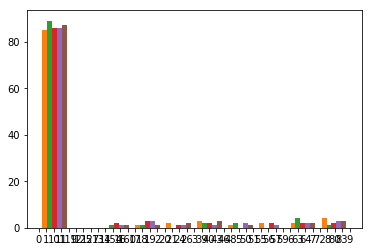

In [72]:
df, bins = get_weights_for_histogram(results1)
plt.hist(df)
plt.show()